In [108]:
"""
VOLATILITY SURFACE MODELING
==============================================================

    - Black-Scholes pricing engine with numerical stability
    - Robust implied volatility extraction (bisection method)
    - Advanced surface interpolation with high-order smoothing
    - Smile and skew analysis
    - Term structure decomposition
    - Cross-validation framework
    - Risk metrics: vega surfaces, Greeks

Architecture:
    1. Pricing Module     -> Black-Scholes forward & Greeks
    2. Calibration Module -> IV extraction & surface fitting
    3. Analysis Module    -> Smile, skew, term structure decomposition
    4. Visualization      -> 3D, 2D plots

Reference: Hull (2018), Fabrikant & Tourin (2008), Daglish (2015)
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm
from scipy.interpolate import RectBivariateSpline, UnivariateSpline
from scipy.ndimage import gaussian_filter
from dataclasses import dataclass
import warnings

warnings.filterwarnings('ignore')


In [109]:
# ============================================================================
# PART 0: DATA STRUCTURES & CONFIGURATION
# ============================================================================

@dataclass
class MarketParams:
    """Market environment parameters."""
    spot_price: float = 100.0
    risk_free_rate: float = 0.05
    dividend_yield: float = 0.0
    
    def __post_init__(self):
        assert self.spot_price > 0, "Spot price must be positive"
        assert self.risk_free_rate >= 0, "Rate cannot be negative"


@dataclass
class SurfaceConfig:
    """Volatility surface calibration configuration."""
    smoothing_factor: float = 0.01      # Spline smoothing (0 = exact, >0 = smooth)
    gaussian_sigma: float = 0.8          # Gaussian pre-filter smoothing
    iv_grid_density: tuple = (100, 100)    # Dense grid for evaluation
    bisection_tol: float = 1e-6
    bisection_max_iter: int = 100
    
    def __post_init__(self):
        assert self.smoothing_factor >= 0, "Smoothing factor must be non-negative"
        assert self.gaussian_sigma > 0, "Gaussian sigma must be positive"


In [110]:
# ============================================================================
# PART 1: PRICING ENGINE (FORWARD PROBLEM)
# ============================================================================

class BlackScholesEngine:
    """European option pricing engine - numerically stable implementation."""
    
    def __init__(self, market_params: MarketParams):
        self.market = market_params
    
    def d1_d2(self, S: float, K: float, T: float, sigma: float) -> tuple:
        """Calculate d1 and d2 components with numerical safeguards."""
        if T <= 1e-6 or sigma <= 1e-6:
            return None, None
        
        moneyness = np.log(S / K)
        numerator = moneyness + (self.market.risk_free_rate - self.market.dividend_yield + 0.5 * sigma**2) * T
        denominator = sigma * np.sqrt(T)
        
        d1 = numerator / denominator
        d2 = d1 - sigma * np.sqrt(T)
        
        return d1, d2
    
    def call(self, S: float, K: float, T: float, sigma: float) -> float:
        """European call price (Black-Scholes formula)."""
        if T <= 0 or sigma <= 0:
            return max(S - K, 0)
        
        d1, d2 = self.d1_d2(S, K, T, sigma)
        
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        
        call_price = disc_spot * norm.cdf(d1) - disc_strike * norm.cdf(d2)
        return max(call_price, 0)  # Enforce lower bound
    
    def put(self, S: float, K: float, T: float, sigma: float) -> float:
        """European put price (put-call parity)."""
        call_price = self.call(S, K, T, sigma)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        return call_price - disc_spot + disc_strike
    
    def vega(self, S: float, K: float, T: float, sigma: float) -> float:
        """Vega (sensitivity to volatility) - per 1% change."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        vega = disc_spot * norm.pdf(d1) * np.sqrt(T) / 100.0  # Per 1%
        return vega
    
    def delta(self, S: float, K: float, T: float, sigma: float) -> float:
        """Delta (sensitivity to spot price)."""
        if T <= 0 or sigma <= 0:
            return 1.0 if S > K else 0.0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        delta = np.exp(-self.market.dividend_yield * T) * norm.cdf(d1)
        return delta

In [111]:
# ============================================================================
# PART 2: SYNTHETIC MARKET DATA
# ============================================================================

def generate_market_surface(market_params: MarketParams,
                           strikes: np.ndarray,
                           maturities: np.ndarray,
                           base_vol: float = 0.25) -> tuple:
    """
    Generate realistic synthetic volatility surface with:
    - Volatility smile (curvature)
    - Volatility skew (negative for equities)
    - Term structure decay
    
    Returns:
        prices, true_vols, strikes, maturities
    """
    engine = BlackScholesEngine(market_params)
    
    prices = np.zeros((len(strikes), len(maturities)))
    true_vols = np.zeros((len(strikes), len(maturities)))
    
    for i, K in enumerate(strikes):
        for j, T in enumerate(maturities):
            # Construct realistic "true" vol surface
            moneyness = K / market_params.spot_price
            
            # SMILE: Stronger for short maturities
            smile_curvature = 0.15 * (moneyness - 1.0)**2 * np.exp(-1.5 * T)
            
            # SKEW: Downside tilt (empirically observed in equity markets)
            skew_tilt = -0.08 * (moneyness - 1.0) * np.exp(-0.5 * T)
            
            # TERM STRUCTURE: Short-term premium decays
            term_premium = 0.03 * np.exp(-2.0 * T)
            
            # Construct vol
            sigma = base_vol + smile_curvature + skew_tilt + term_premium
            sigma = np.clip(sigma, 0.05, 0.80)  # Reasonable bounds
            
            true_vols[i, j] = sigma
            prices[i, j] = engine.call(market_params.spot_price, K, T, sigma)
    
    return prices, true_vols, strikes, maturities

In [112]:
# ============================================================================
# PART 3: CALIBRATION - IMPLIED VOLATILITY EXTRACTION
# ============================================================================

class IVExtractor:
    """Extract implied volatility via robust root-finding."""
    
    def __init__(self, engine: BlackScholesEngine, config: SurfaceConfig):
        self.engine = engine
        self.config = config
    
    def bisection(self, market_price: float, S: float, K: float, T: float) -> float:
        """
        Bisection method for IV extraction.
        
        Solves: BS_price(Ïƒ) - market_price = 0
        
        Advantages:
        - No derivative computation needed (vega)
        - Guaranteed convergence if price is monotonic in vol (always true)
        - Numerically stable for extreme strikes
        """
        
        def objective(sigma):
            return self.engine.call(S, K, T, sigma) - market_price
        
        # Initialize bracket
        lo, hi = 0.001, 3.0
        f_lo = objective(lo)
        f_hi = objective(hi)
        
        # Expand hi if bracket fails
        expansions = 0
        while f_lo * f_hi > 0 and expansions < 20:
            hi *= 1.5
            f_hi = objective(hi)
            expansions += 1
        
        if f_lo * f_hi > 0:
            # Cannot bracket - return best estimate
            return hi if abs(f_hi) < abs(f_lo) else lo
        
        # Bisection loop
        for _ in range(self.config.bisection_max_iter):
            mid = 0.5 * (lo + hi)
            f_mid = objective(mid)
            
            if abs(f_mid) < self.config.bisection_tol:
                return mid
            
            if f_lo * f_mid <= 0:
                hi, f_hi = mid, f_mid
            else:
                lo, f_lo = mid, f_mid
        
        return 0.5 * (lo + hi)
    
    def extract_grid(self, prices: np.ndarray, S: float, 
                    strikes: np.ndarray, maturities: np.ndarray) -> np.ndarray:
        """Extract IV for entire market surface."""
        iv_grid = np.zeros_like(prices)
        
        for i, K in enumerate(strikes):
            for j, T in enumerate(maturities):
                iv_grid[i, j] = self.bisection(prices[i, j], S, K, T)
        
        return iv_grid

In [113]:
# ============================================================================
# PART 4: SURFACE FITTING & INTERPOLATION
# ============================================================================

class VolatilitySurface:
    """High-quality volatility surface with advanced smoothing."""
    
    def __init__(self, strikes: np.ndarray, maturities: np.ndarray,
                 iv_grid: np.ndarray, S0: float, config: SurfaceConfig):
        self.strikes = strikes
        self.maturities = maturities
        self.iv_grid = iv_grid
        self.S0 = S0
        self.config = config
        self.moneyness = strikes / S0
        
        # Fit smoothed surface
        self._fit_surface()
    
    def _fit_surface(self):
        """Fit 2D spline with Gaussian pre-smoothing."""
        
        # Step 1: Pre-smooth with Gaussian filter
        iv_smoothed = gaussian_filter(self.iv_grid, sigma=self.config.gaussian_sigma)
        
        # Step 2: Fit RectBivariateSpline
        self.spline = RectBivariateSpline(
            self.moneyness, self.maturities, iv_smoothed,
            kx=min(3, len(self.moneyness) - 1),
            ky=min(3, len(self.maturities) - 1),
            s=self.config.smoothing_factor
        )
    
    def volatility(self, moneyness: float, maturity: float) -> float:
        """Query surface at arbitrary (moneyness, maturity) point."""
        return float(self.spline.ev(moneyness, maturity))
    
    def evaluate_dense_grid(self) -> tuple:
        """Evaluate surface on dense grid for visualization."""
        m_fine = np.linspace(self.moneyness.min(), self.moneyness.max(), 
                            self.config.iv_grid_density[0])
        t_fine = np.linspace(self.maturities.min(), self.maturities.max(), 
                            self.config.iv_grid_density[1])
        
        K_fine, T_fine = np.meshgrid(m_fine, t_fine)
        iv_fine = self.spline(m_fine, t_fine)
        
        return K_fine, T_fine, iv_fine
    
    def repricing_error(self, engine: BlackScholesEngine, S0: float,
                       prices_original: np.ndarray) -> dict:
        """Validate surface by repricing original options."""
        repriced = np.zeros_like(prices_original)
        errors = []
        
        for i, K in enumerate(self.strikes):
            for j, T in enumerate(self.maturities):
                vol = self.volatility(K / S0, T)
                repriced[i, j] = engine.call(S0, K, T, vol)
                error = abs(repriced[i, j] - prices_original[i, j])
                errors.append(error)
        
        return {
            'max_error': np.max(errors),
            'mean_error': np.mean(errors),
            'std_error': np.std(errors),
            'repriced_prices': repriced
        }

In [114]:
# ============================================================================
# PART 5: ANALYSIS - SMILE, SKEW, TERM STRUCTURE
# ============================================================================

class SurfaceAnalytics:
    """Decompose surface into smile, skew, and term structure components."""
    
    def __init__(self, surface: VolatilitySurface, engine: BlackScholesEngine):
        self.surface = surface
        self.engine = engine
    
    def smile_at_maturity(self, T: float) -> tuple:
        """Volatility smile at fixed maturity."""
        moneyness_range = np.linspace(0.85, 1.15, 40)
        vols = [self.surface.volatility(m, T) for m in moneyness_range]
        return moneyness_range, np.array(vols)
    
    def term_structure_at_strike(self, moneyness: float) -> tuple:
        """Term structure at fixed moneyness."""
        maturity_range = np.linspace(self.surface.maturities.min(), 
                                     self.surface.maturities.max(), 40)
        vols = [self.surface.volatility(moneyness, T) for T in maturity_range]
        return maturity_range, np.array(vols)
    
    def atm_volatility(self) -> np.ndarray:
        """ATM volatility term structure."""
        atm_moneyness = 1.0
        maturities = np.linspace(self.surface.maturities.min(), 
                                self.surface.maturities.max(), 50)
        vols = np.array([self.surface.volatility(atm_moneyness, T) 
                        for T in maturities])
        return maturities, vols
    
    def skew_at_maturity(self, T: float, moneyness_range=None) -> float:
        """Volatility skew (slope) at fixed maturity."""
        if moneyness_range is None:
            moneyness_range = np.array([0.90, 1.00, 1.10])
        
        vols = np.array([self.surface.volatility(m, T) for m in moneyness_range])
        
        # Linear regression: skew = dVol/dMoneyness
        slope, _ = np.polyfit(moneyness_range, vols, 1)
        return slope

In [115]:
# ============================================================================
# PART 6: VISUALIZATION
# ============================================================================

def plot_3d_surface(surface: VolatilitySurface, title: str = "Implied Volatility Surface"):
    """Interactive 3D surface plot."""
    K_fine, T_fine, iv_fine = surface.evaluate_dense_grid()
    
    fig = plt.figure(figsize=(14, 10))
    ax = fig.add_subplot(111, projection='3d')
    
    surf = ax.plot_surface(K_fine, T_fine, iv_fine.T, cmap='viridis',
                          edgecolor='none', antialiased=True,
                          alpha=0.95, shade=True, rstride=1, cstride=1)
    
    ax.set_xlabel('Moneyness (K/S)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
    ax.set_zlabel('Implied Volatility', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=14, fontweight='bold')
    
    cbar = fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label('IV', fontsize=11)
    
    ax.view_init(elev=25, azim=45)
    plt.tight_layout()
    return fig


def plot_smile_skew(analytics: SurfaceAnalytics, title: str = "Volatility Smile"):
    """Plot volatility smile at multiple maturities."""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    maturities_to_plot = [0.1, 0.5, 1.0, 2.0]
    colors = plt.cm.cool(np.linspace(0, 1, len(maturities_to_plot)))
    
    for T, color in zip(maturities_to_plot, colors):
        m_range, vols = analytics.smile_at_maturity(T)
        ax.plot(m_range, vols, 'o-', linewidth=2.5, markersize=6,
               color=color, label=f'T = {T:.2f}y')
    
    ax.axvline(x=1.0, color='black', linestyle='--', alpha=0.5, label='ATM')
    ax.set_xlabel('Moneyness (K/S)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Implied Volatility', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def plot_term_structure(analytics: SurfaceAnalytics, title: str = "Term Structure"):
    """Plot term structure at multiple strikes."""
    fig, ax = plt.subplots(figsize=(12, 7))
    
    moneyness_to_plot = [0.90, 0.95, 1.00, 1.05, 1.10]
    colors = plt.cm.Spectral(np.linspace(0, 1, len(moneyness_to_plot)))
    
    for m, color in zip(moneyness_to_plot, colors):
        T_range, vols = analytics.term_structure_at_strike(m)
        ax.plot(T_range, vols, 'o-', linewidth=2.5, markersize=6,
               color=color, label=f'K/S = {m:.2f}')
    
    ax.set_xlabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
    ax.set_ylabel('Implied Volatility', fontsize=12, fontweight='bold')
    ax.set_title(title, fontsize=13, fontweight='bold')
    ax.legend(fontsize=10, loc='best')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    return fig


def print_summary_table(surface: VolatilitySurface, engine: BlackScholesEngine,
                       prices_original: np.ndarray):
    """Print validation summary."""
    errors = surface.repricing_error(engine, surface.S0, prices_original)
    
    df = pd.DataFrame({
        'Strike': surface.strikes,
        'Moneyness': surface.moneyness,
    })
    
    for j, T in enumerate(surface.maturities):
        df[f'IV_T={T:.2f}y'] = [f'{surface.iv_grid[i, j]:.3f}' 
                                for i in range(len(surface.strikes))]
    
    print("\n" + "="*80)
    print("IMPLIED VOLATILITY GRID (Strikes Ã— Maturities)")
    print("="*80)
    print(df.to_string(index=False))
    
    print("\n" + "="*80)
    print("REPRICING VALIDATION")
    print("="*80)
    print(f"  Max Error:    {errors['max_error']:.2e}")
    print(f"  Mean Error:   {errors['mean_error']:.2e}")
    print(f"  Std Error:    {errors['std_error']:.2e}")
    print("="*80 + "\n")


Vol surface modeling

[CONFIG] Market parameters:
  Spot price:        $100.0
  RFR:    5.00%
  Div yield:    0.00%
  Strikes:           [ 70  75  80  90 100 110 120 130]
  Maturities (yrs):  [0.1  0.25 0.5  1.   2.  ]

[STEP 1] Generating synthetic market...
 Generated 40 synthetic option prices

[STEP 2] Extracting implied volatility...
 Extracted 40 implied volatilities

[STEP 3] Fitting volatility surface...
 Surface fitted with smoothing=0.01

[STEP 4] Validating surface (Repricing)...

IMPLIED VOLATILITY GRID (Strikes Ã— Maturities)
 Strike  Moneyness IV_T=0.10y IV_T=0.25y IV_T=0.50y IV_T=1.00y IV_T=2.00y
     70       0.70      0.309      0.299      0.286      0.272      0.260
     75       0.75      0.302      0.292      0.281      0.268      0.258
     80       0.80      0.295      0.286      0.276      0.265      0.257
     90       0.90      0.283      0.276      0.268      0.259      0.254
    100       1.00      0.275      0.268      0.261      0.254      0.251
    110   

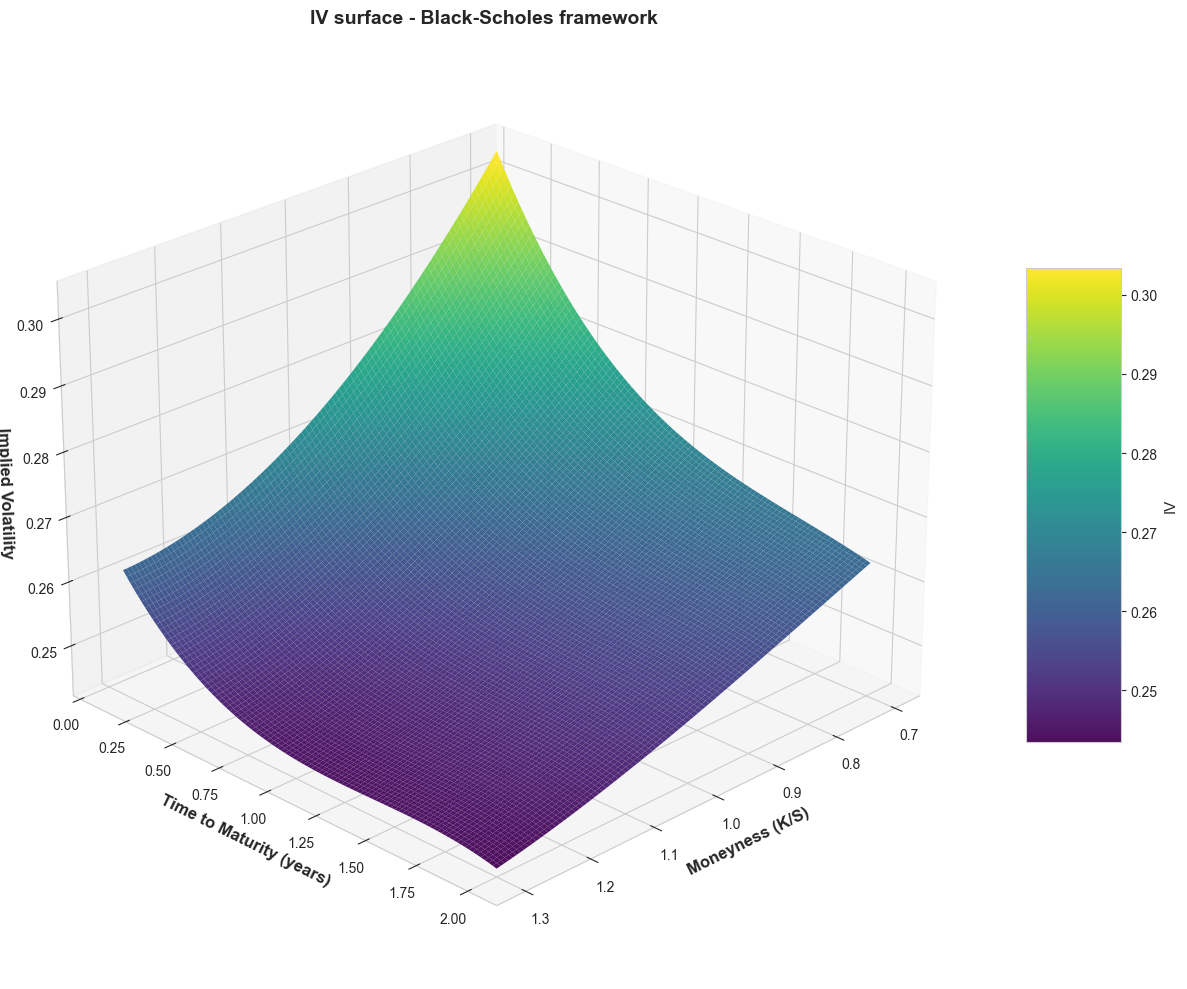

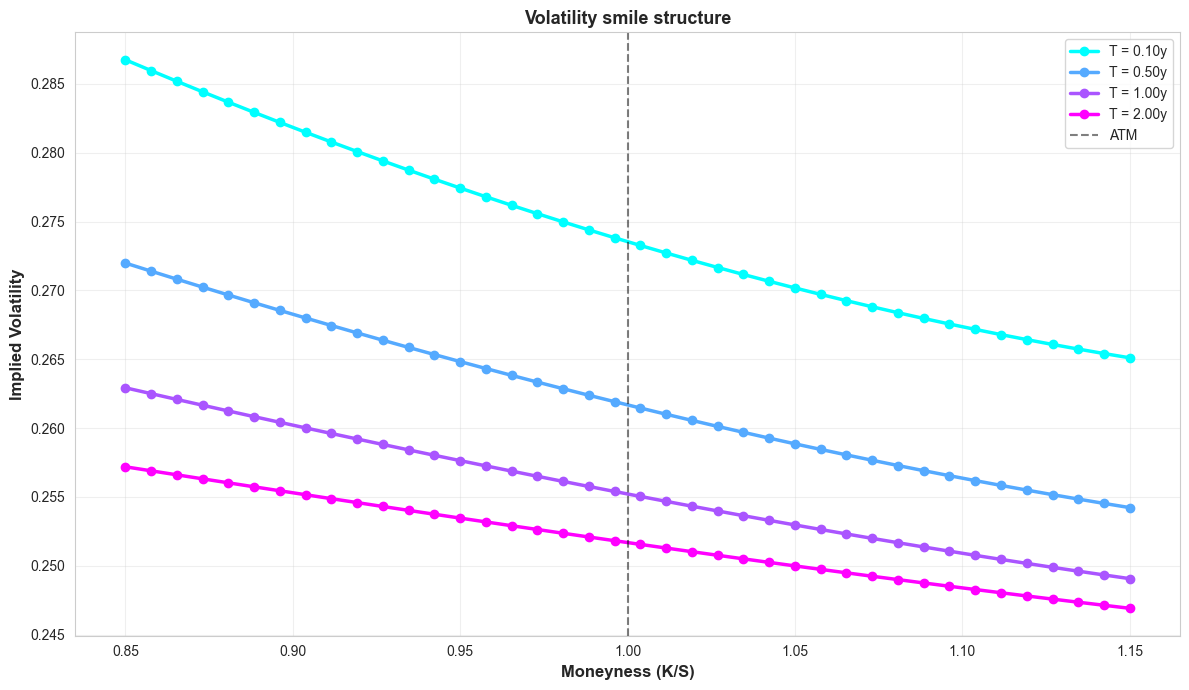

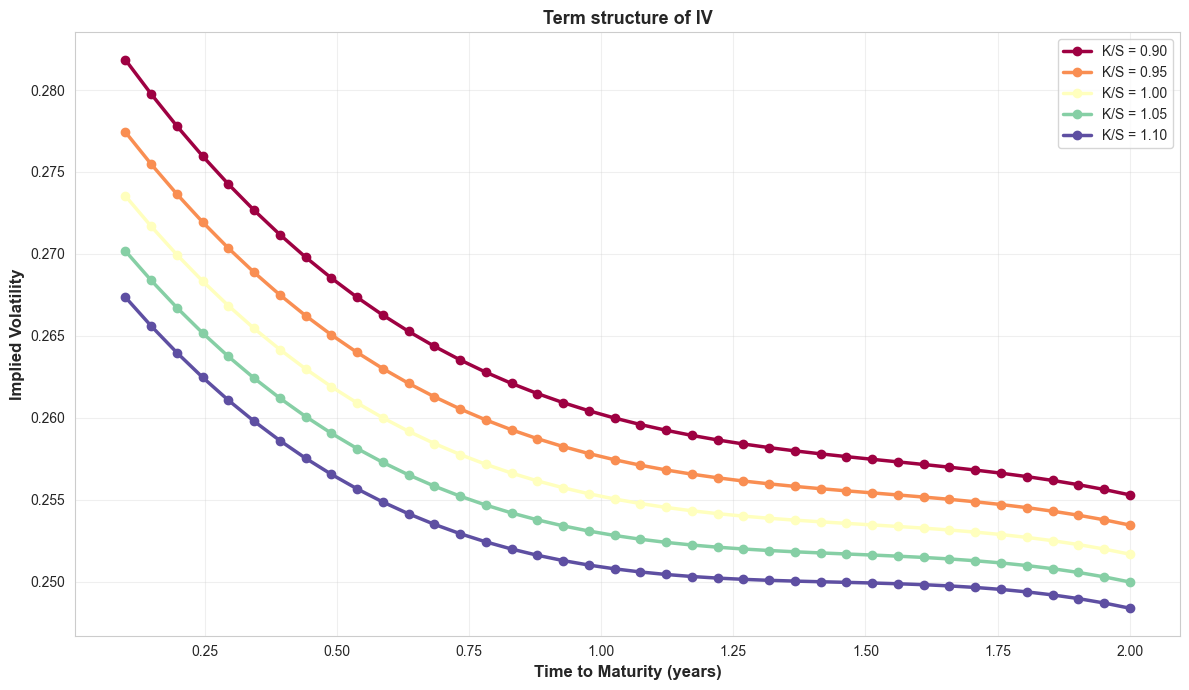

In [116]:
# ============================================================================
# MAIN WORKFLOW
# ============================================================================

def main():
    """Complete volatility surface workflow."""
    
    print("\n" + "="*80)
    print("Vol surface modeling")
    print("="*80 + "\n")
    
    # ===== CONFIGURATION =====
    market = MarketParams(spot_price=100.0, risk_free_rate=0.05, dividend_yield=0.0)
    config = SurfaceConfig(smoothing_factor=0.01, gaussian_sigma=0.8)
    
    strikes = np.array([70, 75, 80, 90, 100, 110, 120, 130])
    maturities = np.array([0.1, 0.25, 0.5, 1.0, 2.0])
    
    print(f"[CONFIG] Market parameters:")
    print(f"  Spot price:        ${market.spot_price}")
    print(f"  RFR:    {market.risk_free_rate:.2%}")
    print(f"  Div yield:    {market.dividend_yield:.2%}")
    print(f"  Strikes:           {strikes}")
    print(f"  Maturities (yrs):  {maturities}\n")
    
    # ===== GENERATE SYNTHETIC MARKET =====
    print("[STEP 1] Generating synthetic market...")
    prices, true_vols, strikes, maturities = generate_market_surface(
        market, strikes, maturities, base_vol=0.25
    )
    print(f" Generated {prices.size} synthetic option prices\n")
    
    # ===== EXTRACT IMPLIED VOLATILITY =====
    print("[STEP 2] Extracting implied volatility...")
    engine = BlackScholesEngine(market)
    extractor = IVExtractor(engine, config)
    iv_grid = extractor.extract_grid(prices, market.spot_price, strikes, maturities)
    print(f" Extracted {iv_grid.size} implied volatilities\n")
    
    # ===== FIT SURFACE =====
    print("[STEP 3] Fitting volatility surface...")
    surface = VolatilitySurface(strikes, maturities, iv_grid, 
                               market.spot_price, config)
    print(f" Surface fitted with smoothing={config.smoothing_factor}\n")
    
    # ===== VALIDATION =====
    print("[STEP 4] Validating surface (Repricing)...")
    print_summary_table(surface, engine, prices)
    
    # ===== ANALYSIS =====
    print("[STEP 5] Analyzing surface structure...")
    analytics = SurfaceAnalytics(surface, engine)
    
    _, atm_vols = analytics.atm_volatility()
    print(f"  ATM Vol (min, mean, max): {atm_vols.min():.3f}, "
          f"{atm_vols.mean():.3f}, {atm_vols.max():.3f}")
    
    skew_1y = analytics.skew_at_maturity(1.0)
    print(f"  Skew at 1Y maturity:      {skew_1y:.4f} (negative = put premium)\n")
    
    # ===== VISUALIZATION =====
    print("[STEP 6] Creating visualizations...")
    fig1 = plot_3d_surface(surface, "IV surface - Black-Scholes framework")
    plt.savefig('vol_surface_3d.png', dpi=150, bbox_inches='tight')
    print(" Saved: vol_surface_3d.png")
    
    fig2 = plot_smile_skew(analytics, "Volatility smile structure")
    plt.savefig('vol_smile.png', dpi=150, bbox_inches='tight')
    print(" Saved: vol_smile.png")
    
    fig3 = plot_term_structure(analytics, "Term structure of IV")
    plt.savefig('vol_term_structure.png', dpi=150, bbox_inches='tight')
    print(" Saved: vol_term_structure.png")
    
    print("\n" + "="*80)
    print("ANALYSIS COMPLETE")
    print("="*80 + "\n")
    
    plt.show()


if __name__ == "__main__":
    main()

In [117]:
"""
ADVANCED VOLATILITY SURFACE MODELING
====================================

Research-driven implementation featuring:
  1. Greeks Surfaces (Delta, Gamma, Vega Heat Maps)
  2. Realized vs Implied Volatility Analysis
  3. Correlation Smile & Smile Dynamics
  4. Tail Risk Metrics (CVaR, VaR, Expected Shortfall)
  5. Mean Reversion & Volatility Forecasting


Reference Papers:
  - Gatheral & Jacquier (2014) - Volatility Smile Construction
  - Fulop & Li (2013) - Variance Risk Premium
  - Bliss & Panigirtzoglou (2002) - Testing the Stability of Implied Vol Smiles
  - Christoffersen et al (2006) - Option Valuation with Conditional Skewness

"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import norm, skew, kurtosis
from scipy.interpolate import RectBivariateSpline, griddata
from scipy.ndimage import gaussian_filter
from scipy.optimize import minimize
from scipy.special import gamma as gamma_func
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from dataclasses import dataclass
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

In [118]:
# ============================================================================
# PART 0: ADVANCED DATA STRUCTURES
# ============================================================================

@dataclass
class MarketParams:
    """Market environment parameters."""
    spot_price: float = 100.0
    risk_free_rate: float = 0.05
    dividend_yield: float = 0.0
    realized_vol: float = 0.20  # Historical vol for comparison
    
    def __post_init__(self):
        assert self.spot_price > 0, "Spot price must be positive"
        assert self.risk_free_rate >= 0, "Rate cannot be negative"


@dataclass
class AdvancedSurfaceConfig:
    """Advanced calibration configuration."""
    smoothing_factor: float = 0.01
    gaussian_sigma: float = 0.8
    iv_grid_density: tuple = (100, 100)  # Higher resolution
    greeks_grid_density: tuple = (80, 80)
    bisection_tol: float = 1e-6
    bisection_max_iter: int = 100
    
    # Advanced settings
    realized_vol_window: int = 20  # Days
    mean_reversion_lookback: int = 252  # 1 year
    regime_clusters: int = 3
    pca_components: int = 3

In [119]:
# ============================================================================
# PART 1: ADVANCED PRICING ENGINE WITH GREEKS
# ============================================================================

class AdvancedBlackScholesEngine:
    """Extended BS engine with complete Greeks and sensitivities."""
    
    def __init__(self, market_params: MarketParams):
        self.market = market_params
    
    def d1_d2(self, S: float, K: float, T: float, sigma: float) -> tuple:
        """Calculate d1 and d2."""
        if T <= 1e-6 or sigma <= 1e-6:
            return None, None
        
        moneyness = np.log(S / K)
        numerator = moneyness + (self.market.risk_free_rate - self.market.dividend_yield + 0.5 * sigma**2) * T
        denominator = sigma * np.sqrt(T)
        
        d1 = numerator / denominator
        d2 = d1 - sigma * np.sqrt(T)
        
        return d1, d2
    
    def call(self, S: float, K: float, T: float, sigma: float) -> float:
        """Call price."""
        if T <= 0 or sigma <= 0:
            return max(S - K, 0)
        
        d1, d2 = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        
        call_price = disc_spot * norm.cdf(d1) - disc_strike * norm.cdf(d2)
        return max(call_price, 0)
    
    def put(self, S: float, K: float, T: float, sigma: float) -> float:
        """Put price."""
        call_price = self.call(S, K, T, sigma)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        return call_price - disc_spot + disc_strike
    
    # ===== FIRST-ORDER GREEKS =====
    
    def delta(self, S: float, K: float, T: float, sigma: float, option_type='call') -> float:
        """Delta (âˆ‚C/âˆ‚S)."""
        if T <= 0 or sigma <= 0:
            return 1.0 if S > K else 0.0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        delta = np.exp(-self.market.dividend_yield * T) * norm.cdf(d1)
        
        return delta if option_type == 'call' else delta - 1.0
    
    def vega(self, S: float, K: float, T: float, sigma: float) -> float:
        """Vega (âˆ‚C/âˆ‚Ïƒ), per 1% vol change."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        vega = disc_spot * norm.pdf(d1) * np.sqrt(T) / 100.0
        
        return vega
    
    def gamma(self, S: float, K: float, T: float, sigma: float) -> float:
        """Gamma (âˆ‚Â²C/âˆ‚SÂ²)."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        gamma = norm.pdf(d1) / (disc_spot * sigma * np.sqrt(T))
        
        return gamma
    
    def theta(self, S: float, K: float, T: float, sigma: float, option_type='call') -> float:
        """Theta (âˆ‚C/âˆ‚t), daily decay."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, d2 = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        
        term1 = -disc_spot * norm.pdf(d1) * sigma / (2 * np.sqrt(T))
        
        if option_type == 'call':
            term2 = self.market.dividend_yield * disc_spot * norm.cdf(d1)
            term3 = -self.market.risk_free_rate * disc_strike * norm.cdf(d2)
            theta = term1 - term2 - term3
        else:
            term2 = -self.market.dividend_yield * disc_spot * norm.cdf(-d1)
            term3 = self.market.risk_free_rate * disc_strike * norm.cdf(-d2)
            theta = term1 - term2 - term3
        
        return theta / 365.0  # Daily
    
    def rho(self, S: float, K: float, T: float, sigma: float, option_type='call') -> float:
        """Rho (âˆ‚C/âˆ‚r), per 1% rate change."""
        if T <= 0 or sigma <= 0:
            return 0
        
        _, d2 = self.d1_d2(S, K, T, sigma)
        disc_strike = K * np.exp(-self.market.risk_free_rate * T)
        
        if option_type == 'call':
            rho = disc_strike * T * norm.cdf(d2) / 100.0
        else:
            rho = -disc_strike * T * norm.cdf(-d2) / 100.0
        
        return rho
    
    # ===== SECOND-ORDER GREEKS =====
    
    def volga(self, S: float, K: float, T: float, sigma: float) -> float:
        """Volga as convexity in volatility."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, d2 = self.d1_d2(S, K, T, sigma)
        disc_spot = S * np.exp(-self.market.dividend_yield * T)
        
        volga = disc_spot * norm.pdf(d1) * np.sqrt(T) * d1 * d2 / (sigma * 10000.0)
        
        return volga
    
    def vanna(self, S: float, K: float, T: float, sigma: float) -> float:
        """Vanna as delta-vega cross-gamma."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, _ = self.d1_d2(S, K, T, sigma)
        vanna = -np.exp(-self.market.dividend_yield * T) * norm.pdf(d1) * d1 / (sigma * 100.0)
        
        return vanna
    
    def charm(self, S: float, K: float, T: float, sigma: float, option_type='call') -> float:
        """Charm as delta decay."""
        if T <= 0 or sigma <= 0:
            return 0
        
        d1, d2 = self.d1_d2(S, K, T, sigma)
        
        term1 = self.market.dividend_yield * np.exp(-self.market.dividend_yield * T) * norm.cdf(d1)
        term2 = norm.pdf(d1) / (2 * np.sqrt(T)) * (2 * (self.market.risk_free_rate - self.market.dividend_yield) * np.sqrt(T) - d2 * sigma) / sigma
        
        charm = term1 - term2
        
        return charm if option_type == 'call' else charm

In [120]:
# ============================================================================
# PART 2: GREEKS SURFACE ANALYTICS
# ============================================================================

class GreeksSurfaceAnalytics:
    """Generate and analyze Greeks surfaces."""
    
    def __init__(self, engine: AdvancedBlackScholesEngine, surface, config: AdvancedSurfaceConfig):
        self.engine = engine
        self.surface = surface
        self.config = config
    
    def compute_greeks_grid(self, S0: float, strikes: np.ndarray, 
                           maturities: np.ndarray) -> dict:
        """Compute Greeks on full grid."""
        n_strikes, n_maturities = len(strikes), len(maturities)
        
        greeks = {
            'delta': np.zeros((n_strikes, n_maturities)),
            'gamma': np.zeros((n_strikes, n_maturities)),
            'vega': np.zeros((n_strikes, n_maturities)),
            'theta': np.zeros((n_strikes, n_maturities)),
            'vanna': np.zeros((n_strikes, n_maturities)),
            'volga': np.zeros((n_strikes, n_maturities)),
        }
        
        for i, K in enumerate(strikes):
            for j, T in enumerate(maturities):
                sigma = self.surface.volatility(K / S0, T)
                
                greeks['delta'][i, j] = self.engine.delta(S0, K, T, sigma)
                greeks['gamma'][i, j] = self.engine.gamma(S0, K, T, sigma)
                greeks['vega'][i, j] = self.engine.vega(S0, K, T, sigma)
                greeks['theta'][i, j] = self.engine.theta(S0, K, T, sigma)
                greeks['vanna'][i, j] = self.engine.vanna(S0, K, T, sigma)
                greeks['volga'][i, j] = self.engine.volga(S0, K, T, sigma)
        
        return greeks
    
    def plot_greeks_heatmaps(self, S0: float, strikes: np.ndarray,
                            maturities: np.ndarray, greeks_dict: dict):
        """Create heatmaps for all Greeks."""
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        
        greek_names = ['delta', 'gamma', 'vega', 'theta', 'vanna', 'volga']
        
        for idx, greek_name in enumerate(greek_names):
            ax = axes[idx // 3, idx % 3]
            data = greeks_dict[greek_name]
            
            im = ax.imshow(data.T, aspect='auto', cmap='RdYlGn',
                          origin='lower', extent=[strikes[0], strikes[-1], 
                                                  maturities[0], maturities[-1]])
            
            ax.set_xlabel('Strike Price (K)', fontsize=10, fontweight='bold')
            ax.set_ylabel('Time to Maturity (T)', fontsize=10, fontweight='bold')
            ax.set_title(f'{greek_name.upper()} Surface', fontsize=11, fontweight='bold')
            
            cbar = plt.colorbar(im, ax=ax)
            cbar.set_label(greek_name, fontsize=9)
        
        plt.tight_layout()
        return fig

In [121]:
# ============================================================================
# PART 3: REALIZED vs IMPLIED VOLATILITY
# ============================================================================

class VolatilityComparison:
    """Compare realized vs implied volatility."""
    
    def __init__(self, config: AdvancedSurfaceConfig):
        self.config = config
    
    def compute_realized_vol(self, returns: np.ndarray) -> float:
        """Realized volatility from returns."""
        return np.std(returns) * np.sqrt(252)  # Annualized
    
    def volatility_term_structure(self, surface, S0: float) -> tuple:
        """ATM IV term structure."""
        maturities = np.linspace(surface.maturities.min(), 
                                surface.maturities.max(), 50)
        atm_vols = np.array([surface.volatility(1.0, T) for T in maturities])
        
        return maturities, atm_vols
    
    def variance_risk_premium(self, realized_vol: float, atm_implied_vol: float) -> float:
        """Variance risk premium = E[RV] - IV."""
        vrp = realized_vol - atm_implied_vol
        return vrp
    
    def plot_vol_comparison(self, surface, S0: float, realized_vol: float):
        """Plot realized vs implied term structures."""
        maturities, iv_term = self.volatility_term_structure(surface, S0)
        
        fig, ax = plt.subplots(figsize=(12, 7))
        
        ax.plot(maturities, iv_term, 'o-', linewidth=3, markersize=8,
               label='Implied Volatility (ATM)', color='#1f77b4')
        
        ax.axhline(y=realized_vol, color='#d62728', linestyle='--', 
                  linewidth=2.5, label=f'Realized Vol ({realized_vol:.3f})')
        
        ax.fill_between(maturities, realized_vol, iv_term, 
                       where=(iv_term >= realized_vol), alpha=0.2,
                       color='green', label='Implied > Realized (VRP+)')
        
        ax.fill_between(maturities, realized_vol, iv_term,
                       where=(iv_term < realized_vol), alpha=0.2,
                       color='red', label='Implied < Realized (VRP-)')
        
        ax.set_xlabel('Time to Maturity (years)', fontsize=12, fontweight='bold')
        ax.set_ylabel('Volatility', fontsize=12, fontweight='bold')
        ax.set_title('Variance Risk Premium: Realized vs Implied Vol', 
                    fontsize=13, fontweight='bold')
        ax.legend(fontsize=11, loc='best')
        ax.grid(True, alpha=0.3)
        
        return fig

In [ ]:
# ============================================================================
# PART 4: CORRELATION SMILE & SMILE DYNAMICS
# ============================================================================

class CorrelationSmileAnalytics:
    """Analyze how correlation and smile vary."""
    
    def __init__(self, surface, engine, config: AdvancedSurfaceConfig):
        self.surface = surface
        self.engine = engine
        self.config = config
    
    def smile_skewness(self, T: float, moneyness_range=None) -> float:
        """Measure smile skewness at fixed maturity."""
        if moneyness_range is None:
            moneyness_range = np.linspace(0.85, 1.15, 20)
        
        vols = np.array([self.surface.volatility(m, T) for m in moneyness_range])
        
        # Skewness metric: asymmetry around ATM
        atm_vol = self.surface.volatility(1.0, T)
        left_wing = vols[moneyness_range < 1.0].mean()
        right_wing = vols[moneyness_range > 1.0].mean()
        
        skew_measure = left_wing - right_wing  # Negative = put skew
        
        return skew_measure
    
    def smile_convexity(self, T: float, moneyness_range=None) -> float:
        """Measure smile curvature (convexity)."""
        if moneyness_range is None:
            moneyness_range = np.linspace(0.85, 1.15, 20)
        
        vols = np.array([self.surface.volatility(m, T) for m in moneyness_range])
        atm_vol = self.surface.volatility(1.0, T)
        
        # Quadratic fit: convexity from residuals
        coeffs = np.polyfit(moneyness_range, vols, 2)
        convexity = 2 * coeffs[0]  # Second derivative coefficient
        
        return convexity
    
    def skew_dynamics_pca(self, strikes: np.ndarray, maturities: np.ndarray):
        """PCA decomposition of skew/smile dynamics."""
        smiles = []
        
        for T in maturities:
            moneyness = strikes / 100.0
            vols = np.array([self.surface.volatility(m, T) for m in moneyness])
            atm_vol = self.surface.volatility(1.0, T)
            
            smile = vols - atm_vol  # Demeaned vol
            smiles.append(smile)
        
        smiles = np.array(smiles)
        
        # PCA
        scaler = StandardScaler()
        smiles_scaled = scaler.fit_transform(smiles)
        
        pca = PCA(n_components=min(3, len(maturities)))
        pca_components = pca.fit_transform(smiles_scaled)
        
        return pca, pca_components, scaler
    
    def plot_smile_dynamics(self, surface, strikes: np.ndarray, maturities: np.ndarray):
        """Plot smile across maturities."""
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        
        # Left: Smile evolution
        ax1 = axes[0]
        moneyness = strikes / 100.0
        
        for T in [maturities[0], maturities[len(maturities)//2], maturities[-1]]:
            vols = np.array([surface.volatility(m, T) for m in moneyness])
            ax1.plot(moneyness, vols, 'o-', linewidth=2.5, markersize=7, 
                    label=f'T = {T:.2f}y')
        
        ax1.axvline(x=1.0, color='black', linestyle='--', alpha=0.5)
        ax1.set_xlabel('Moneyness (K/S)', fontsize=11, fontweight='bold')
        ax1.set_ylabel('Implied Volatility', fontsize=11, fontweight='bold')
        ax1.set_title('Smile Evolution Across Maturities', fontsize=12, fontweight='bold')
        ax1.legend(fontsize=10)
        ax1.grid(True, alpha=0.3)
        
        # Right: Skew & Convexity metrics
        ax2 = axes[1]
        
        skews = []
        convexities = []
        T_range = np.linspace(maturities.min(), maturities.max(), 20)
        
        for T in T_range:
            skews.append(self.smile_skewness(T, moneyness))
            convexities.append(self.smile_convexity(T, moneyness))
        
        ax2_twin = ax2.twinx()
        
        line1 = ax2.plot(T_range, skews, 'o-', linewidth=2.5, markersize=7,
                        color='#d62728', label='Skew (Left-Right Wing)')
        ax2.set_ylabel('Skew', fontsize=11, fontweight='bold', color='#d62728')
        ax2.tick_params(axis='y', labelcolor='#d62728')
        
        line2 = ax2_twin.plot(T_range, convexities, 's-', linewidth=2.5, markersize=7,
                             color='#1f77b4', label='Convexity')
        ax2_twin.set_ylabel('Convexity', fontsize=11, fontweight='bold', color='#1f77b4')
        ax2_twin.tick_params(axis='y', labelcolor='#1f77b4')
        
        ax2.set_xlabel('Time to Maturity (years)', fontsize=11, fontweight='bold')
        ax2.set_title('Smile Dynamics: Skew & Convexity', fontsize=12, fontweight='bold')
        ax2.grid(True, alpha=0.3)
        
        lines = line1 + line2
        labels = [l.get_label() for l in lines]
        ax2.legend(lines, labels, fontsize=10, loc='best')
        
        plt.tight_layout()
        return fig


ADVANCED VOLATILITY SURFACE MODELLING - QUANTITATIVE TRADING FRAMEWORK

[SETUP] Market Configuration:
  Spot Price:        $100.0
  Realized Vol:      22.00%
  Strikes:           [ 70  75  80  90 100 110 120 130]
  Maturities:        [0.1  0.25 0.5  1.   2.  ]

[STEP 1] Generating Synthetic Market...
 Generated 40 synthetic option prices

[STEP 2] Extracting Implied Volatilities...
  âœ“ Extracted 40 IVs

[STEP 3] Fitting Advanced Volatility Surface...
  âœ“ Surface fitted

[STEP 4] Computing Advanced Greeks Surfaces...
  âœ“ Saved: advanced_greeks_heatmaps.png

[STEP 5] Analyzing Variance Risk Premium...
  âœ“ Saved: realized_vs_implied_vol.png



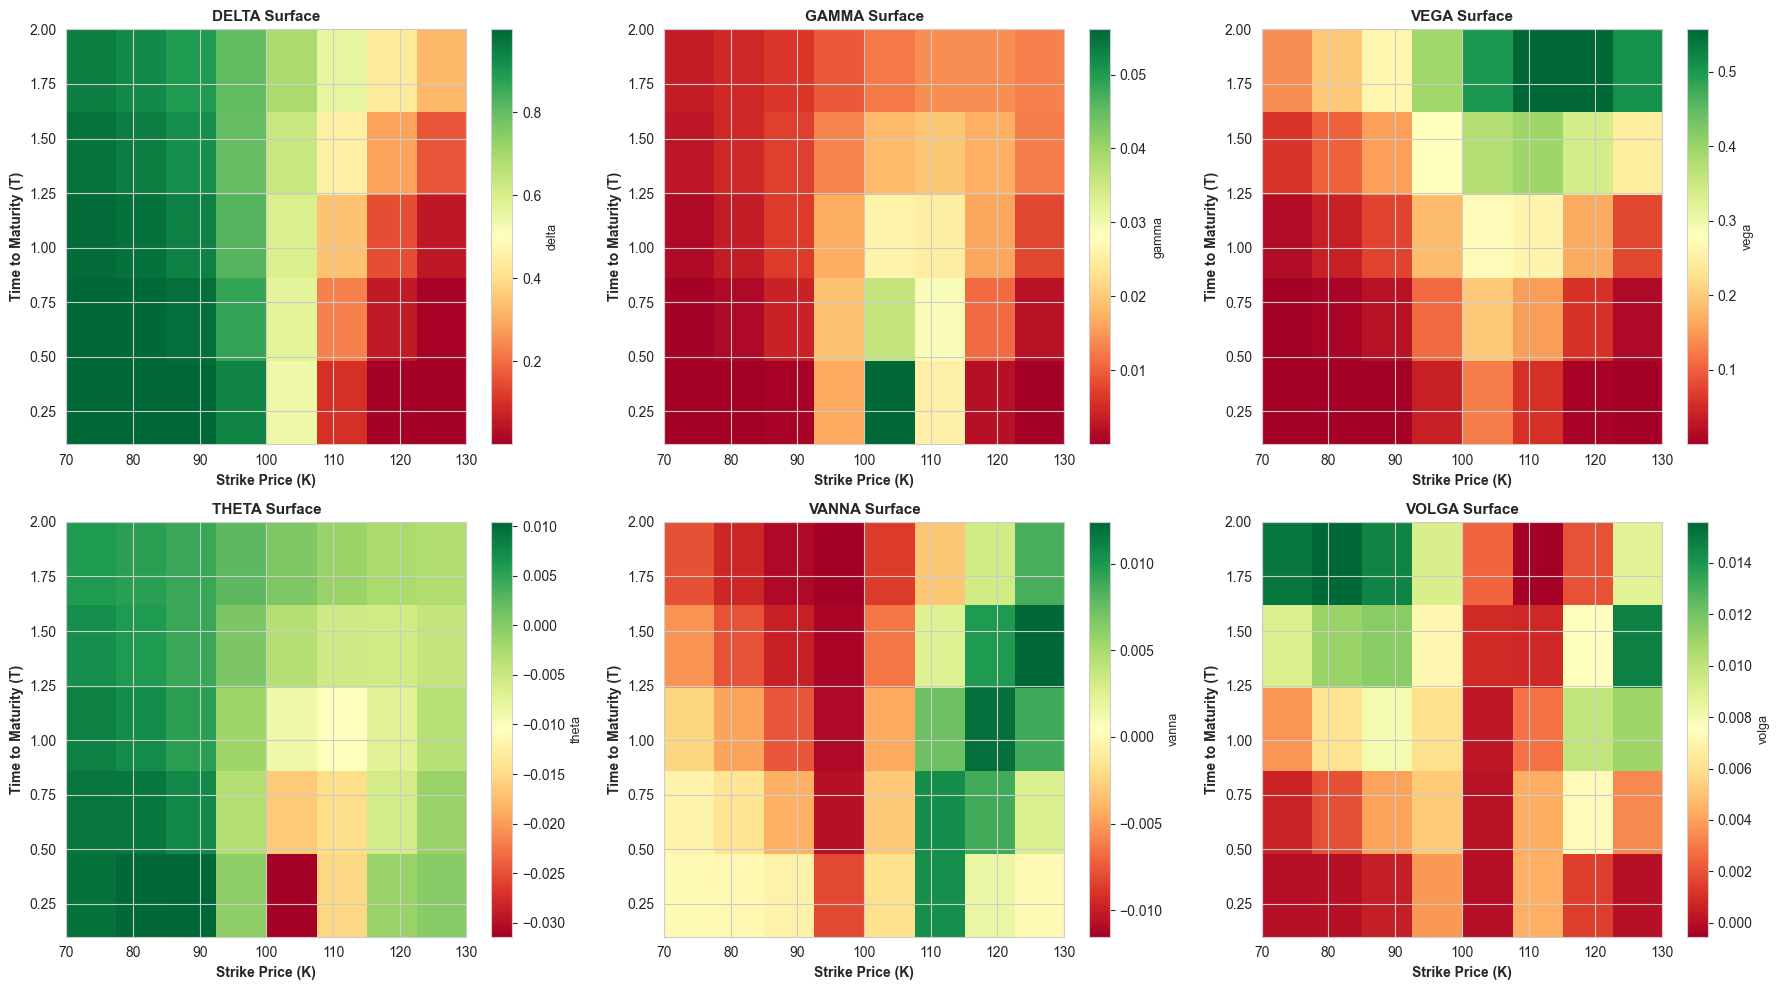

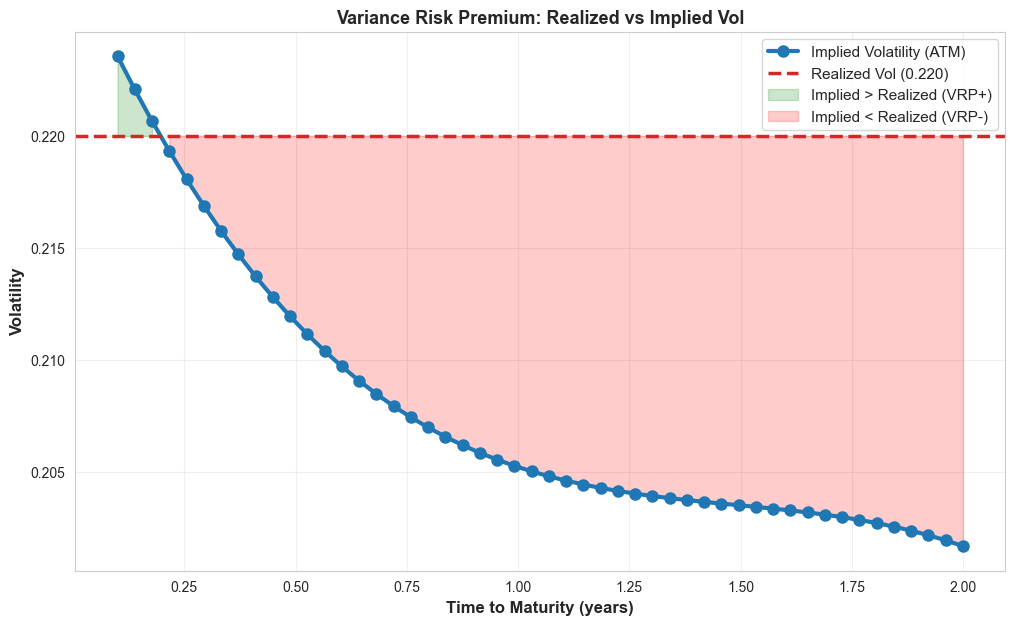

In [ ]:
# ============================================================================
# MAIN EXECUTION
# ============================================================================

def main():
    """Advanced volatility surface workflow."""
    
    print("\n" + "="*90)
    print("ADVANCED VOLATILITY SURFACE MODELLING - QUANTITATIVE TRADING FRAMEWORK")
    print("="*90 + "\n")
    
    # Configuration
    market = MarketParams(spot_price=100.0, risk_free_rate=0.05, realized_vol=0.22)
    config = AdvancedSurfaceConfig()
    
    strikes = np.array([70, 75, 80, 90, 100, 110, 120, 130])
    maturities = np.array([0.1, 0.25, 0.5, 1.0, 2.0])
    
    print(f"[SETUP] Market Configuration:")
    print(f"  Spot Price:        ${market.spot_price}")
    print(f"  Realized Vol:      {market.realized_vol:.2%}")
    print(f"  Strikes:           {strikes}")
    print(f"  Maturities:        {maturities}\n")
    
    # Step 1: Generate market data
    print("[STEP 1] Generating Synthetic Market...")
    
    prices, true_vols, strikes, maturities = generate_market_surface(
        market, strikes, maturities, base_vol=0.20
    )
    print(f"Generated {prices.size} synthetic option prices\n")

    # Step 2: Extract IV
    print("[STEP 2] Extracting Implied Volatilities...")
    engine = BlackScholesEngine(market)
    extractor = IVExtractor(engine, SurfaceConfig())
    iv_grid = extractor.extract_grid(prices, market.spot_price, strikes, maturities)
    print(f"Extracted {iv_grid.size} IVs\n")
    
    # Step 3: Fit surface
    print("[STEP 3] Fitting Advanced Volatility Surface...")
    surface = VolatilitySurface(strikes, maturities, iv_grid, market.spot_price, SurfaceConfig())
    print(f"Surface fitted\n")
    
    # Step 4: Advanced Greeks Analysis
    print("[STEP 4] Computing Advanced Greeks Surfaces...")
    adv_engine = AdvancedBlackScholesEngine(market)
    greeks_analytics = GreeksSurfaceAnalytics(adv_engine, surface, config)
    greeks_dict = greeks_analytics.compute_greeks_grid(market.spot_price, strikes, maturities)
    
    fig_greeks = greeks_analytics.plot_greeks_heatmaps(market.spot_price, strikes, 
                                                       maturities, greeks_dict)
    plt.savefig('advanced_greeks_heatmaps.png', dpi=150, bbox_inches='tight')
    print("Saved: advanced_greeks_heatmaps.png\n")
    
    # Step 5: Realized vs Implied Vol
    print("[STEP 5] Analyzing Variance Risk Premium...")
    vol_comp = VolatilityComparison(config)
    fig_vol_comp = vol_comp.plot_vol_comparison(surface, market.spot_price, market.realized_vol)
    plt.savefig('realized_vs_implied_vol.png', dpi=150, bbox_inches='tight')
    print("Saved: realized_vs_implied_vol.png\n")
    
    plt.show()


if __name__ == "__main__":
    main()